In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Activation, BatchNormalization, Conv2D, MaxPooling2D, Reshape
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

from keras.callbacks import ReduceLROnPlateau
from keras.initializers import glorot_uniform

from IPython.display import Audio
import noisereduce as nr

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
import pickle
with open('podcast_train_arrays.pkl', 'rb') as handle:
    podcast_train_arrays = pickle.load(handle)
with open('crowd_train_labels.pkl', 'rb') as handle:
    crowd_train_labels = pickle.load(handle)
with open('podcast_test_labels.pkl', 'rb') as handle:
    podcast_test_labels = pickle.load(handle)
with open('podcast_train_labels.pkl', 'rb') as handle:
    podcast_train_labels = pickle.load(handle)
with open('crowd_train_arrays.pkl', 'rb') as handle:
    crowd_train_arrays = pickle.load(handle)
with open('crowd_test_arrays.pkl', 'rb') as handle:
    crowd_test_arrays = pickle.load(handle)
with open('crowd_test_labels.pkl', 'rb') as handle:
    crowd_test_labels = pickle.load(handle)
with open('podcast_test_arrays.pkl', 'rb') as handle:
    podcast_test_arrays = pickle.load(handle)

In [ ]:
import pandas as pd
df_train = pd.DataFrame([], columns=['array', 'emotion'])
df_train['array'] = crowd_train_arrays
df_train['emotion'] = crowd_train_labels
df_train = df_train.sample(frac=0.3, random_state=0)

podcast_df_train = pd.DataFrame([], columns=['array', 'emotion'])
podcast_df_train['array'] = podcast_train_arrays
podcast_df_train['emotion'] = podcast_train_labels

df_train = df_train.append(podcast_df_train)

In [ ]:
df_test = pd.DataFrame([], columns=['array', 'emotion'])
df_test['array'] = crowd_test_arrays
df_test['emotion'] = crowd_test_labels


podcast_df_test = pd.DataFrame([], columns=['array', 'emotion'])
podcast_df_test['array'] = podcast_test_arrays
podcast_df_test['emotion'] = podcast_test_labels

df_test = df_test.append(podcast_df_test)

In [ ]:
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)

In [ ]:
def extract_mfcc(data, sr=16000):
    data = nr.reduce_noise(data, sr=sr)
    total_length = sr*5
    xt, index = librosa.effects.trim(data, top_db=33)
    xt = np.pad(xt[:total_length], (0, total_length-len(xt)), 'constant')
    mfcc = librosa.feature.mfcc(y=xt, sr=sr, n_mfcc=13)
    return np.array(mfcc).astype('float32')

In [ ]:
def extract_logmel(data, sr=16000):
    data = nr.reduce_noise(data, sr=sr)
    total_length = sr*5
    xt, index = librosa.effects.trim(data, top_db=33)
    xt = np.pad(xt[:total_length], (0, total_length-len(xt)), 'constant')
    mels = librosa.feature.melspectrogram(y=xt, sr=sr)
    log_mels = librosa.power_to_db(mels)
    return np.array(log_mels).astype('float32')

In [ ]:
%%time
df_train['cleaned'] = df_train['array'].apply(extract_mfcc)
df_test['cleaned'] = df_test['array'].apply(extract_mfcc)

CPU times: total: 1h 34min 26s
Wall time: 15min 46s


In [ ]:
X_train = df_train['cleaned']
X_test = df_test['cleaned']
y_train = df_train['emotion']
y_test = df_test['emotion']

X_train = np.swapaxes(np.dstack(X_train.to_numpy()), 0, 2).astype(np.float32)
X_test = np.swapaxes(np.dstack(X_test.to_numpy()), 0, 2).astype(np.float32)

ohe = OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = ohe.transform(np.array(y_test).reshape(-1,1)).toarray()

In [ ]:
model = Sequential([
    BatchNormalization(input_shape=X_train.shape[1:]),
    Conv1D(128, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.35),
    Conv1D(256, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(4, activation='softmax')
])

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

checkpoint = ModelCheckpoint('cnn_lstm_best_model_mfcc.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0001)

n_epochs = 25
history = model.fit(X_train, y_train, batch_size=128, epochs=n_epochs, validation_data=(X_test, y_test), callbacks=[rlrp, checkpoint])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_5 (Batc  (None, 157, 13)          52        
 hNormalization)                                                 
                                                                 
 conv1d_20 (Conv1D)          (None, 156, 128)          3456      
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 78, 128)          0         
 g1D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 78, 128)           0         
                                                                 
 conv1d_21 (Conv1D)          (None, 77, 256)           65792     
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 38, 256)         

114/114 [==============================] - 13s 114ms/step - loss: 0.9815 - accuracy: 0.5864 - val_loss: 1.0437 - val_accuracy: 0.5608 - lr: 0.0010
Epoch 18/25
114/114 [==============================] - ETA: 0s - loss: 0.9700 - accuracy: 0.5909
Epoch 18: val_accuracy did not improve from 0.56079
114/114 [==============================] - 13s 114ms/step - loss: 0.9700 - accuracy: 0.5909 - val_loss: 1.0530 - val_accuracy: 0.5496 - lr: 0.0010
Epoch 19/25
114/114 [==============================] - ETA: 0s - loss: 0.9718 - accuracy: 0.5886
Epoch 19: val_accuracy improved from 0.56079 to 0.56231, saving model to cnn_lstm_best_model_mfcc.h5
114/114 [==============================] - 13s 113ms/step - loss: 0.9718 - accuracy: 0.5886 - val_loss: 1.0199 - val_accuracy: 0.5623 - lr: 0.0010
Epoch 20/25
114/114 [==============================] - ETA: 0s - loss: 0.9509 - accuracy: 0.6033
Epoch 20: val_accuracy did not improve from 0.56231
114/114 [==============================] - 13s 113ms/step - los

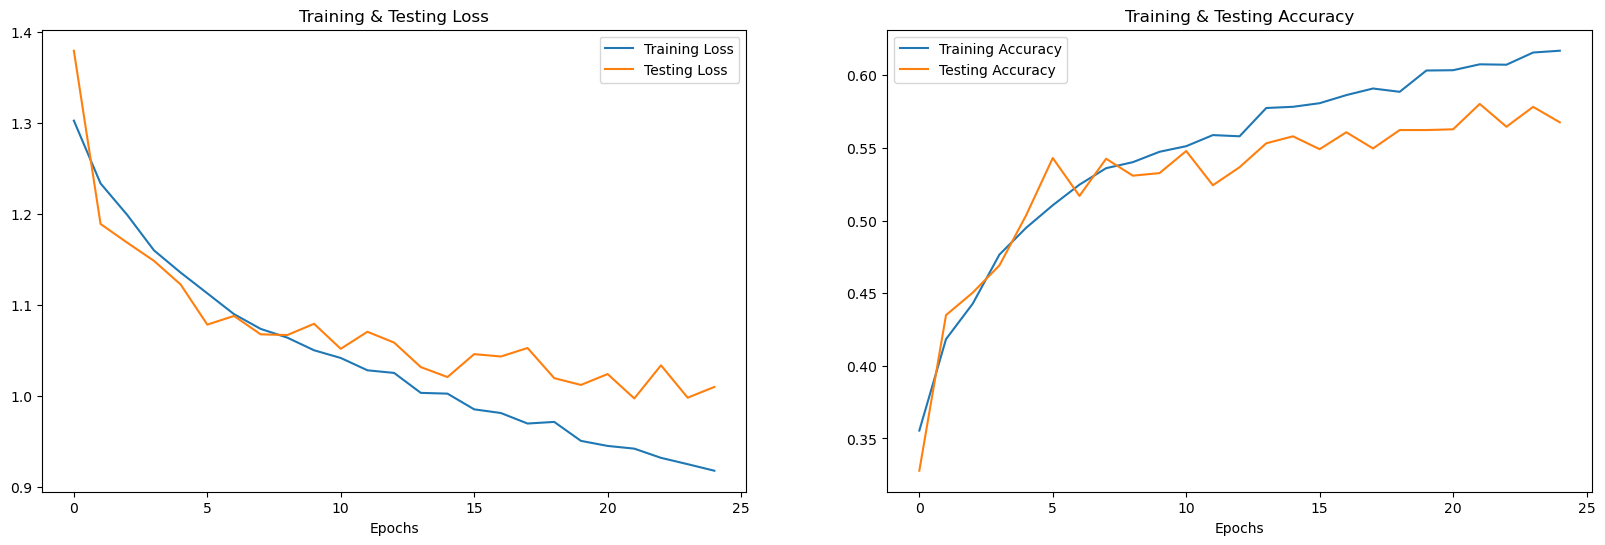

In [ ]:
epochs = [i for i in range(n_epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
pred_test = model.predict(X_test)
y_pred = ohe.inverse_transform(pred_test)
y_test_ = ohe.inverse_transform(y_test)

124/124 [==============================] - 2s 11ms/step


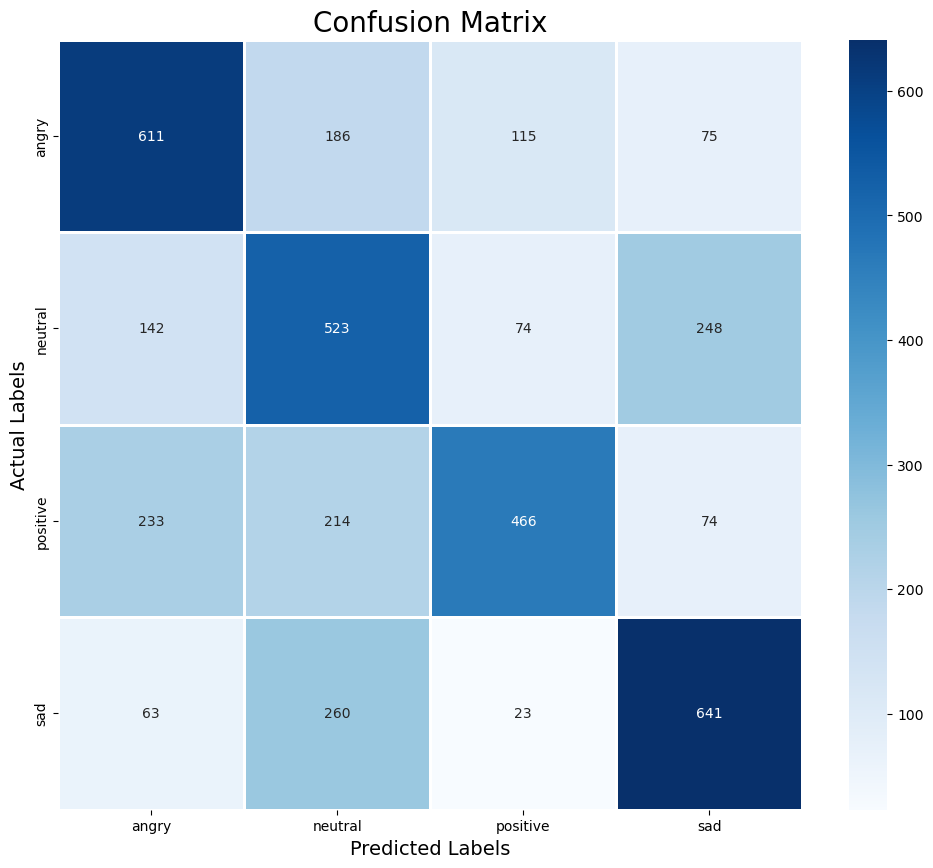

In [ ]:
cm = confusion_matrix(y_test_, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in ohe.categories_] , columns = [i for i in ohe.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
%%time
df_train['cleaned'] = df_train['array'].apply(extract_logmel)
df_test['cleaned'] = df_test['array'].apply(extract_logmel)

CPU times: total: 2h 37min 43s
Wall time: 26min 17s


In [ ]:
X_train = df_train['cleaned']
X_test = df_test['cleaned']
y_train = df_train['emotion']
y_test = df_test['emotion']

X_train = np.swapaxes(np.dstack(X_train.to_numpy()), 0, 2).astype(np.float32)
X_test = np.swapaxes(np.dstack(X_test.to_numpy()), 0, 2).astype(np.float32)

ohe = OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = ohe.transform(np.array(y_test).reshape(-1,1)).toarray()

In [ ]:
model = Sequential([
    BatchNormalization(input_shape=X_train.shape[1:]),
    Conv1D(128, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.35),
    Conv1D(256, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(4, activation='softmax')
])

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

checkpoint = ModelCheckpoint('cnn_lstm_best_model_mels.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0001)

n_epochs = 35
history = model.fit(X_train, y_train, batch_size=128, epochs=n_epochs, validation_data=(X_test, y_test), callbacks=[rlrp, checkpoint])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 157, 128)         512       
 hNormalization)                                                 
                                                                 
 conv1d_24 (Conv1D)          (None, 156, 128)          32896     
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 78, 128)          0         
 g1D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 78, 128)           0         
                                                                 
 conv1d_25 (Conv1D)          (None, 77, 256)           65792     
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 38, 256)         

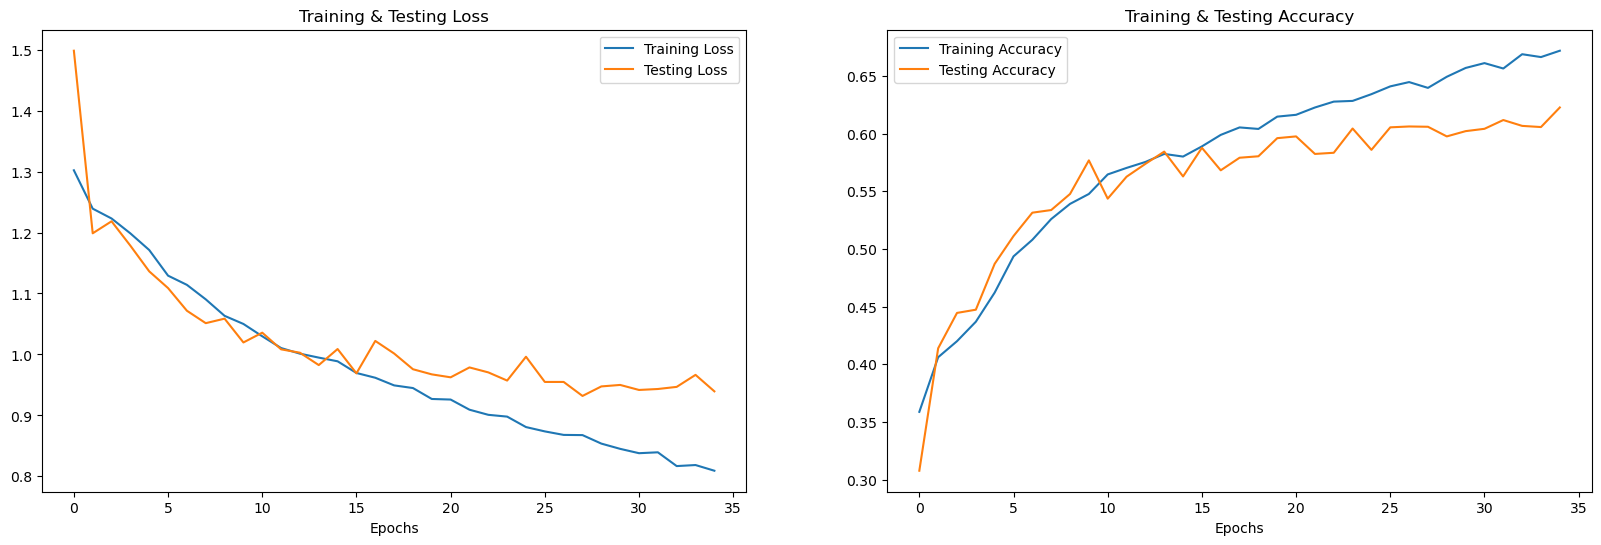

In [ ]:
epochs = [i for i in range(n_epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
pred_test = model.predict(X_test)
y_pred = ohe.inverse_transform(pred_test)
y_test_ = ohe.inverse_transform(y_test)

124/124 [==============================] - 9s 69ms/step


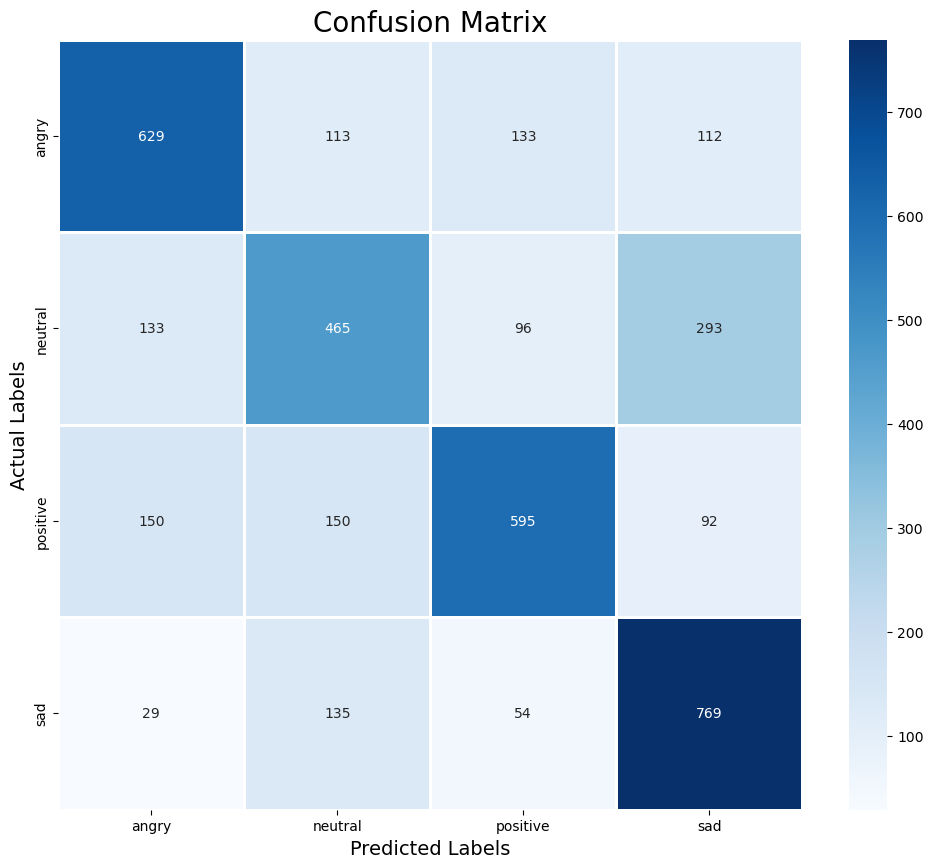

In [ ]:
cm = confusion_matrix(y_test_, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in ohe.categories_] , columns = [i for i in ohe.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()